![](https://mcd.unison.mx/wp-content/themes/awaken/img/logo_mcd.png)

# Ejemplo de Regresión lineal

## Aprendizaje Automático Aplicado

## Maestría en Ciencia de Datos

**Ivo Jiménez** y **Julio Waissman**, 2022

**Alumno: jose Luis Bracamonte Amavizca**

[Abrir en google Colab](https://colab.research.google.com/github/mcd-aaa/blob/master/reg_lineal.ipynb)

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (16,8)
plt.style.use('ggplot')

## 1. Un ejemplo en una sola dimensión

Vamos a abrir y a visualizar unos datos que se encuentran en el archivo `carretas.txt` (abrelos con un editor de texto si quieres ver el archivo original). En este archivo se tiene las ganancias anuales (en dolares) de unos tacos de carreta (bueno, su equivalente gringo) respecto al tamaño de la ciudad donde se encuentra la carreta. Estos datos provienen de el curso de *Machine learning* de *coursera* de *Andrew Ng*.



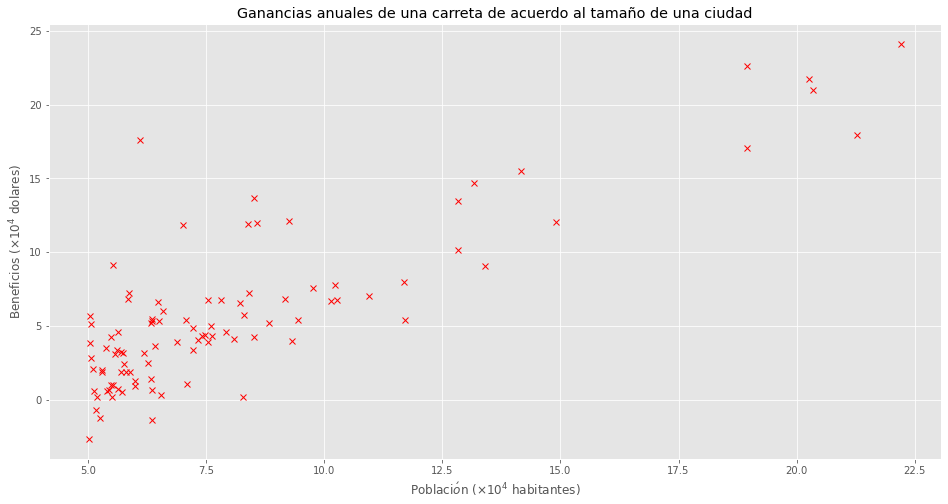

In [140]:
# Lee los datos en un nd array llamado datos

url = 'https://github.com/mcd-unison/aaa-curso/raw/main/ejemplos/carretas.txt'
datos = np.loadtxt(url, comments='%', delimiter=',')

# Separa los datos de entrada de los de salida.
# si decimos que x = datos[:,0], pues se toma solo una columna de datos,
# por lo que x sería un ndarray de forma (shape) (96,). Al decir x = datos[:, 0:1] 
# significa que vamos a tomar todas las columnas de 0 a una antes de 1, por lo
# que x tiene una forma (96, 1). Para mantener generalidad, es mejor manejar x como una matriz
# de una sola columna que como un vector de una dimensión.
x, y = datos[:,0:1], datos[:,1]

# T es el número de instancias y n el de atributos
T, n = x.shape

plt.plot(x, y, 'rx')
plt.title(u'Ganancias anuales de una carreta de acuerdo al tamaño de una ciudad')
plt.xlabel(r"Poblaci$\'o$n ($\times 10^4$ habitantes)")
plt.ylabel(r'Beneficios ($\times 10^4$ dolares)')
plt.show()

Listo, ya temos los datos. La hipótesis que hacemos es que el valor de salida lo podemos estimar como

$$
\hat{y}^{(i)} = h_{\theta}(x^{(i)}) = \omega_1 x^{(i)} + b, \quad \theta = (b, \omega_1)
$$


El criterio MSE como función de pérdida es el de minimizar el costo definido como
$$
E_{in}(\omega, b) = \frac{1}{2M} \sum_{i = 1}^M (y^{(i)} - \hat{y}^{(i)})^2.
$$

Por lo tanto, para saber si estamos minimizando o no, debemos ser capaces de medir la función de pérdida. 

**Desarrolla la función de costo tal como se pide abajo**

In [5]:
def mse(x, y, w, b):
    """
    Calcula el costo de acuerdo al criterio de MSE (mean square error) asumiendo un conjunto de datos
    x, con una salida y, y una hipótesis lineal parametrizada por omega
    
    Parámetros
    ----------
    x: Un ndarray de dimension (M, n)
    y: Un ndarray de dimensión (M, )
    w: Un ndarray de dimensión (n, )
    b: Un flotante
    
    Devuelve
    --------
    Un flotante con el costo
    
    """
    M, n = x.shape
    loss = 0
        
    # Puedes hacerlo en forma de ciclos
    #  J = 0
    #  for i in range(M):
    #     y_hat = x[i] @ w.T + b
    #     J += np.square( y[i] - y_hat)
    #  loss =  J / (2*M) 
    
    # Puedes hacerlo directamente usando numpy
    J = x @ w.T + b  - y
    loss = (J.T @ J )/(2 * M) # Vectorized implementation

    return loss
   

y para probar si está bien el programa, si calculamos $E_in(\omega, b)$ para $\omega_1 = 0$, $b = 1$ debe de dar (para este conjunto de datos) **26.73** (recuerda verificar que regrese un flotante y no un vector de un solo elemento).

In [56]:
w = np.zeros([n])
b = 1
print("El error en muestra es {}".format(mse(x, y, w, b)))

El error en muestra es 26.733598825909272


Muy bien, ya podemos calcular el criterio a optimizar. Vamos entonces a utilizar la función que acabamos de hacer para ver sus valores para diferentes valores de $\omega$ y $b$.

Text(0.5, 1.0, 'Función de pérdida')

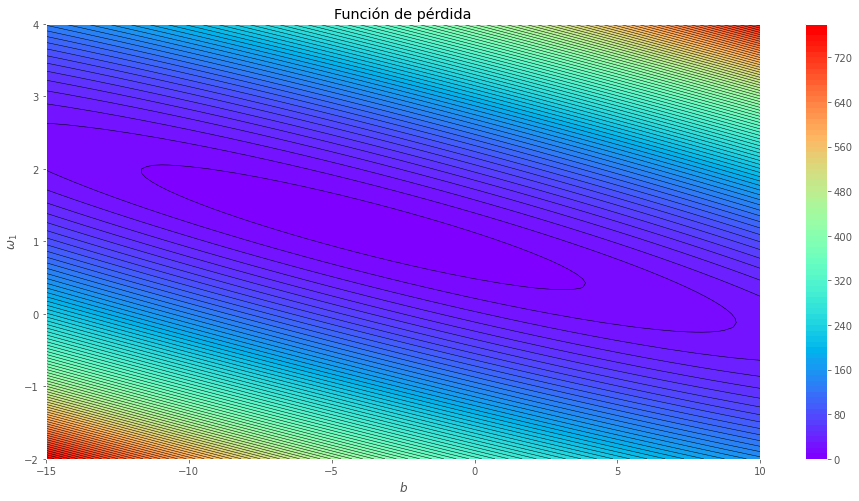

In [8]:
# Definimos una función de burrito (wrap) que depende solo de b y theta1
def costo_w(b, w1):
    return mse(x, y, np.array([w1]), b)

# Y ahora la convertimos en una función tipo numpy (aplica para cualquier entrada de ndarrays)
costo_vect = np.frompyfunc(costo_w, 2, 1)

#Ahora generamos la lista de valores para graficar
b = np.linspace(-15, 10, 100);
w1 = np.linspace(-2, 4, 100);

# Y los convertimos en matrices utilizando la función meshgrid
b, w1 = np.meshgrid(b, w1)

# Y calculamos los costos para cada par de theta0 y theta 1 con nuestra nueva funcion de costos vectorizada
J = costo_vect(b, w1)

# Y graficamos el contorno
plt.contour(b, w1, J, 80, linewidths=0.5, colors='k')
plt.contourf(b, w1, J, 80, cmap=plt.cm.rainbow, vmax=J.max(), vmin=J.min())
plt.colorbar()
plt.xlabel(r"$b$")
plt.ylabel(r"$\omega_1$")
plt.title(r"Función de pérdida")
        

Ahora si, ya tenemos todo para hacer nuestra función para encontrar los parámetros que optimicen la función de costo (que como se puede ver en la superficie debería de estar por donde $b$ vale entre 0 y -5 y $\omega_1$ entre 1 y 2). 

**Desarrolla la función con descenso de gradiente.**

In [167]:
def grad_costo(x, y, w, b):
    """
    Calcula el gradiente respecto a w y b de los datos existentes
    
    Parámetros
    ----------
    x: ndarray de dimension [M, n] con la matriz de diseño
    y: ndarray de dimension [M,] con los valores de salida
    w: ndarray de dimension [n, ] con los pesos 
    b: flotante con el sesgo 
    
    Devuelve
    --------
    dw, db: donde dw es un vector de dimension de w con el gradiente
            de la función de costo respecto a w, y db es la derivada de la
            funcion de costo respecto a b

    """
    m,n = x.shape
    # check reshape of parameteres
    if len(y.shape) == 1:
        y = y.reshape(-1,1)
    w = w.reshape(1,-1)
    #print("y:{} x:{}, w:{}, b:{}".format(y.shape, x.shape, w.shape, b))
    error = y - (x @ w.T + b)
    # --aqui hay que poner código--   
    db = error.mean()
    # check if the error vector need to be copied n times
    # v1 vectorized
    # if len(w) > 1:
    #     # The error matrix is m x 1,  repeat it by the number of params of w
    #     # it be with the sahpe M x n
    #     error = np.tile(error,(1,len(w)))
    # # elemnt-wise multiplication and then  a sum by column. 
    # dw = (error * x).sum(axis=0)/m
    # end v1 vectorized
    # v2 vectorized, simplified
    dw = (x.T @ error).reshape(n)/m
    # The derivative in w is a vector with n elements 
    # and db is an scalar
    #------------------------------
    # print("error:{} dw:{} db:{}".format(error.shape, dw, db ))
    return dw, db 

In [97]:
a = np.array([1,2,3])
#np.tile(a,(3,1))
y_hat = x @ w.reshape((1,1)).T
l = (y.reshape(-1,1) - y_hat)
#l[:5,:]
np.tile(l,(1,3)).sum(axis=0).shape
#len(w.reshape((1,1)))
# mse(x,y,w,b)
w.reshape((1,1))

array([[-171443.04831195]])

In [134]:
def descenso_gradiente_lotes(x, y, w_0, b_0, nu, max_epoch):
    """
    Descenso de gradiente durante num_iter iteraciones para regresión lineal
    
    Parámetros
    -----------
    x: ndarray de dimension [M, n] con los datos de entrada
    y: ndarray de dimension [M,] con los datos de salida
    w_0: ndarray de dimension [n, ] con los pesos iniciales
    b_0: flotante con el sesgo inicial
    nu: flotante con tamaño de paso o tasa de aprendizaje.
    max_epoch: numero de iteraciones (entero)
    
    Devuelve
    --------
    w, b, mse_iter: donde w y b tiene las dimensiones de w_0 y b_0 con los parámetros 
                    aprendidos, mientras que mse_hist es un ndarray de dimensión 
                    [num_iter, 1] con el costo en cada iteración.
    
    """
    w, b = w_0.copy(), b_0
    mse_iter = np.zeros(max_epoch)    
    m, n = x.shape
    for iter in range(max_epoch):
        
        dw, db = grad_costo(x, y, w, b)
        
        # --aqui hay que poner código--        
        w = w + nu * dw
        b = b + nu * db    
        #------------------------------

        mse_iter[iter] = mse(x, y, w, b)
        if iter % 100 == 0:
            print("Batch:{:.0f} loss:{:f}".format(iter/100, mse_iter[iter]))

    return w, b, mse_iter
     

Y para saber si el algoritmo se programo bien, se puede probar en el problema del *food truck* y revisar si el valor de la función de pérdida se va reduciendo hasta estabilizarse en un mínimo.

Batch:0 loss:6.737190
Batch:1 loss:5.476363
Batch:2 loss:5.173635
Batch:3 loss:4.962606
Batch:4 loss:4.815501
Batch:5 loss:4.712956
Batch:6 loss:4.641474
Batch:7 loss:4.591644
Batch:8 loss:4.556908
Batch:9 loss:4.532694
Batch:10 loss:4.515815
Batch:11 loss:4.504049
Batch:12 loss:4.495847
Batch:13 loss:4.490129
Batch:14 loss:4.486143


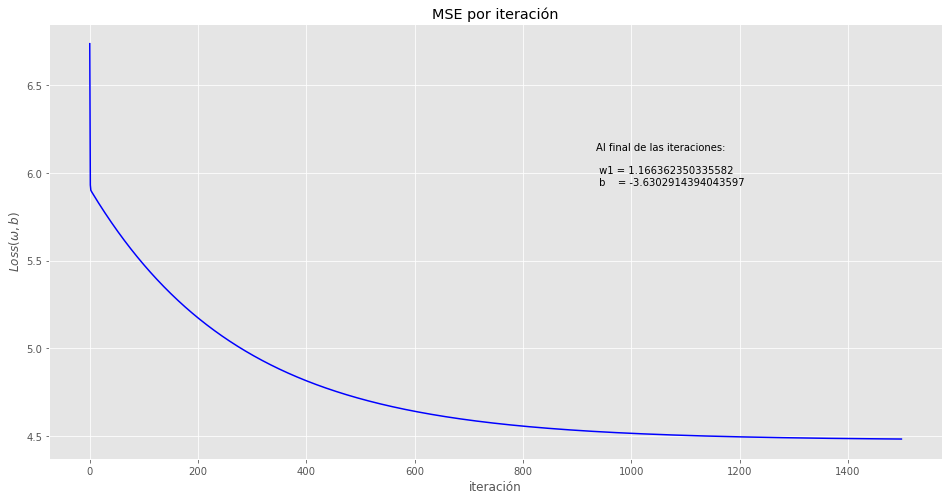

In [141]:
M, n = x.shape
w_0 = np.zeros((n,))
b_0 = 0.0

iteraciones = 1500
alpha = 0.01

w, b, mse_historial = descenso_gradiente_lotes(x, y, w_0, b_0, alpha, iteraciones)


plt.plot(mse_historial, 'b')
plt.title(u'MSE por iteración')
plt.xlabel(u'iteración')
plt.ylabel(r'$Loss(\omega, b)$')
plt.figtext(x=.6, y=.6, s="Al final de las iteraciones:\n\n w1 = {}\n b    = {}".format(w[0], b))
plt.show()

Ahora vamos a revisar virtualmente si la estimación es una linea recta que pasa entre todos los puntos.

**Completa los pasos para realizar la estimación.**

In [142]:
x_estimar = np.array([[4],[24]])

#
# Agrega el codigo necesario
#
y_estimado = x_estimar @ w.T + b

print("Los valores estimados son: {}".format(y_estimado))

Los valores estimados son: [ 1.03515796 24.36240497]


Si los valores que obtuviste son cercanos a 1 (10000 dolares) y 24.3 (243000 dolares) entonces estamos en los valores esperados. Ahora vamos a usar estos valores para graficar los datos reales y la estimación realizada:

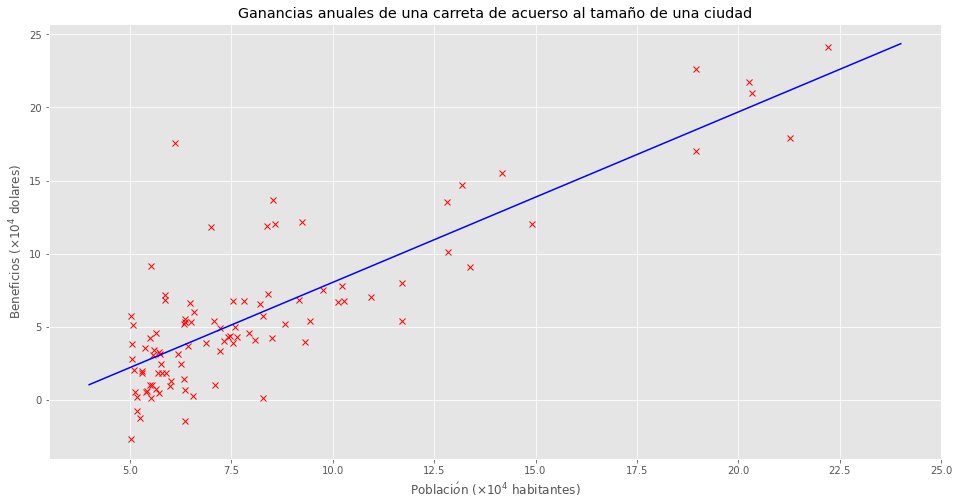

In [143]:
plt.plot(x[:], y, 'xr')
plt.plot(x_estimar[:,0], y_estimado, '-b')
plt.title(u'Ganancias anuales de una carreta de acuerso al tamaño de una ciudad')
plt.xlabel(r"Poblaci$\'o$n ($\times 10^4$ habitantes)")
plt.ylabel(r'Beneficios ($\times 10^4$ dolares)')
plt.show()

**¡Felicidades!** Acabas de terminar el algoritmo de aprendizaje más usado en el mundo.

# 2. Un ejemplo en multiples dimensiones

Como el algortimo realizado ya funciona para muchas dimensiones, no se espera tener mucho problema para utilizarlos. Así que ahora vamos a cargar datos y vamos a graficar la salida respecto a dos variables

Text(0.5, 0, 'cuartos')

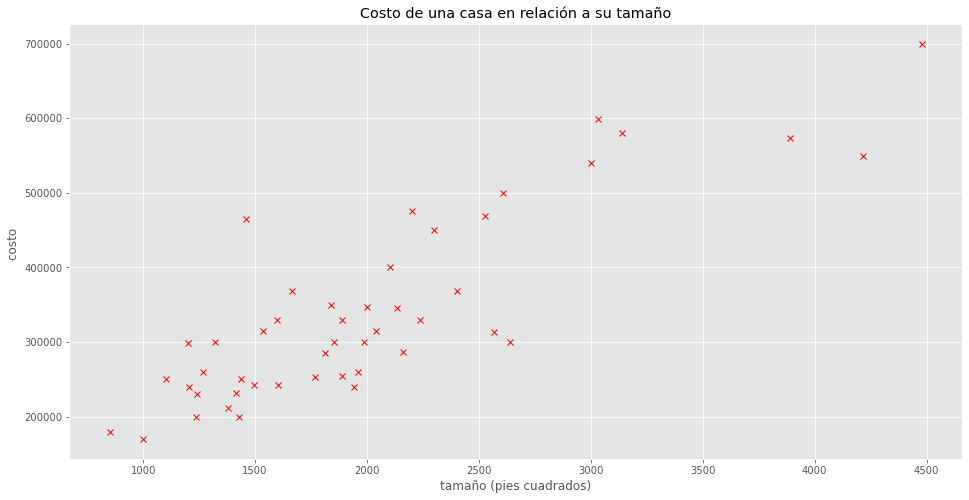

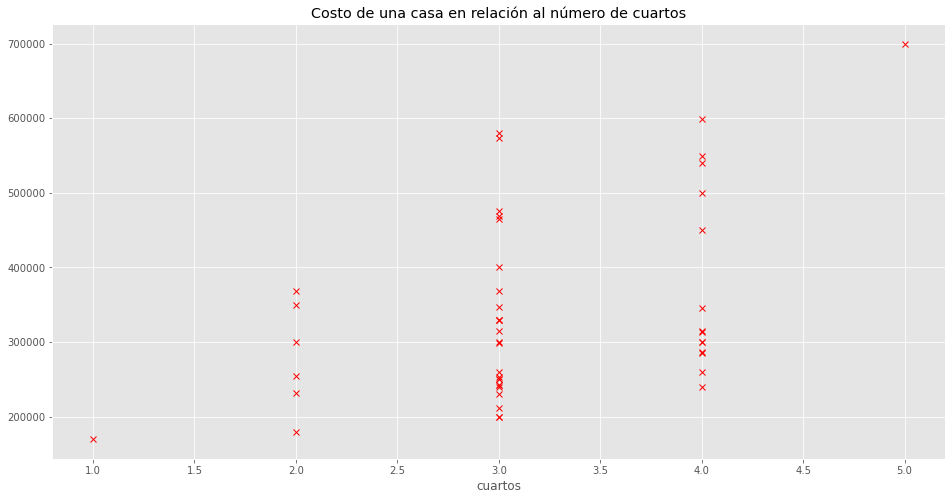

In [156]:
url = "https://github.com/mcd-unison/aaa-curso/raw/main/ejemplos/casas_portland.txt"
datos = np.loadtxt(url, comments='%', delimiter=',')
x, y = datos[:, :-1], datos[:,-1] 

# M es el número de instancias y n el de atributos
m, n = x.shape

plt.plot(x[:,0], y, 'rx')
plt.title(u'Costo de una casa en relación a su tamaño')
plt.xlabel(u"tamaño (pies cuadrados)")
plt.ylabel('costo ')

plt.figure()
plt.plot(x[:,1], y, 'rx')
plt.title(u'Costo de una casa en relación al número de cuartos')
plt.xlabel("cuartos")



Antes de realizar el aprendizaje podemos ver que mientras una de las variables se mide en miles de pies cuadrados, la otra variable tiene valores de 1 a 4. Esto es un problema para el algoritmo del descenso de gradiente, por lo que es necesario normalizar los datos (solo para este algoritmo) y que funcione de manera correcta. 

Para normalizar requerimos de dos pasos, por un lado, obtener los valores de medias y desviaciones estandares por atributo, y en segundo lugar, realizar la normalización. Los valores de medias y desviaciones estandares hay que guardarlos, ya que serán necesarios para poder normalizar los datos que se quiera estimar.

**Estas funciones ya las hicimos realizadas pero revisalas por favor.**

In [118]:
def obtiene_medias_desviaciones(x):
    """
    Obtiene las medias y las desviaciones estandar atributo a atributo.
    
    Parámetros
    ----------
    x: un ndarray de dimensión (T, n) donde T es el númro de elementos y 
       n el número de atributos
    
    Devuelve
    ---------
    medias, desviaciones: donde ambos son ndarrays de dimensiones (n,) con 
                          las medias y las desviaciones estandar respectivamente.
    
    """
    medias = x.mean(axis = 0)
    desviaciones = x.std(axis = 0)
    return medias, desviaciones

    
def normaliza(x, medias, desviaciones):
    """
    Normaliza los datos x

    Parámetros
    ----------
    x: un ndarray de dimensión (T, n) donde T es el númro de elementos y n el número de atributos
    medias: ndarray de dimensiones (n,) con las medias con las que se normalizará
    desviaciones: ndarray de dimensiones (n,) con las desviaciones con las que se normalizará
    
    Devuelve
    --------
    x_norm, un ndarray de las mismas dimensiones de x pero normalizado
    
    """
    return (x - medias) / desviaciones
        

# Y ahora vamos a hacer algo muy simple para probar, que pueden corroborar con el uso de una calculadora común.
x_prueba = np.array([[1, 300],
                    [3, 100],
                    [2, 400],
                    [4, 200]])
m, d = obtiene_medias_desviaciones(x_prueba)

print("Los datos son: \n{}".format(x_prueba))
print("Las medias son: \n{}".format(m))
print("Las desviaciones son: \n{}".format(d))
print("Los datos normalizados son: \n{}".format(normaliza(x_prueba, m, d)))


Los datos son: 
[[  1 300]
 [  3 100]
 [  2 400]
 [  4 200]]
Las medias son: 
[  2.5 250. ]
Las desviaciones son: 
[  1.11803399 111.80339887]
Los datos normalizados son: 
[[-1.34164079  0.4472136 ]
 [ 0.4472136  -1.34164079]
 [-0.4472136   1.34164079]
 [ 1.34164079 -0.4472136 ]]


Listo, entonces ya podemos hacer descenso de gradiente, o casi. El problema es que no sabemos cual sería el mejor valor para $\alpha$. Escoge el valor de $\alpha$ realizando una gráfica de 50 iteraciones solamente para valores desde 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, ... y decide cual de los valores es el que más te conviene.

**Selecciona un valor, especifica aquí cual es, y justifica porque lo seleccionaste.**

Batch:0 loss:65461556490.590111
Batch:0 loss:64942955427.973198
Batch:0 loss:64297776251.620117
Batch:0 loss:59259228917.516869
Batch:0 loss:53268259941.691582
Batch:0 loss:17629115807.239510
Batch:0 loss:3801704819.550019


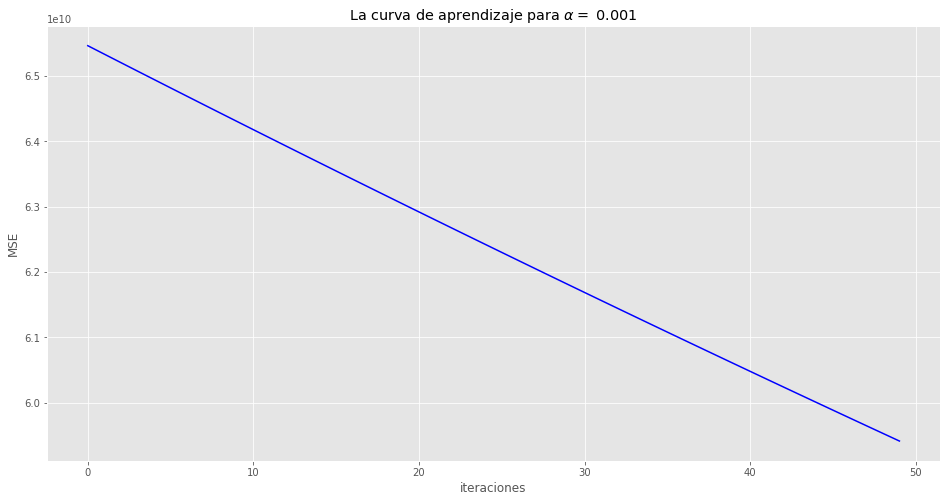

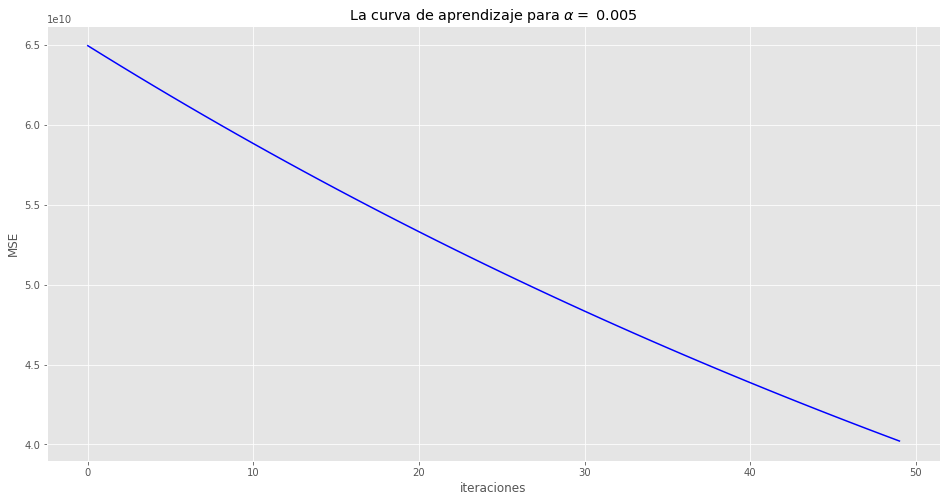

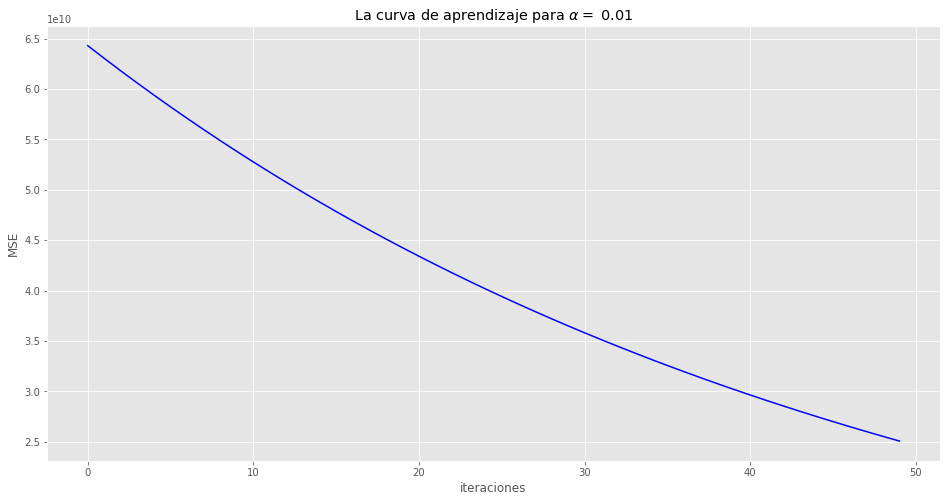

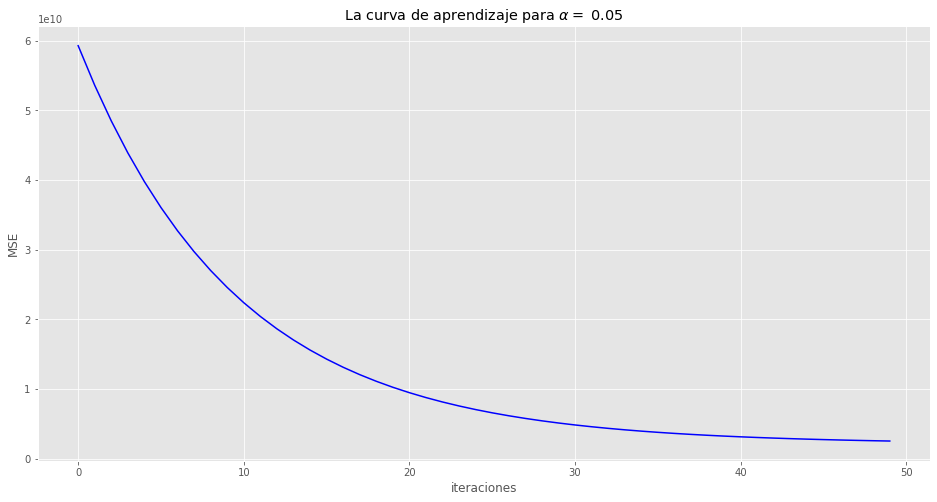

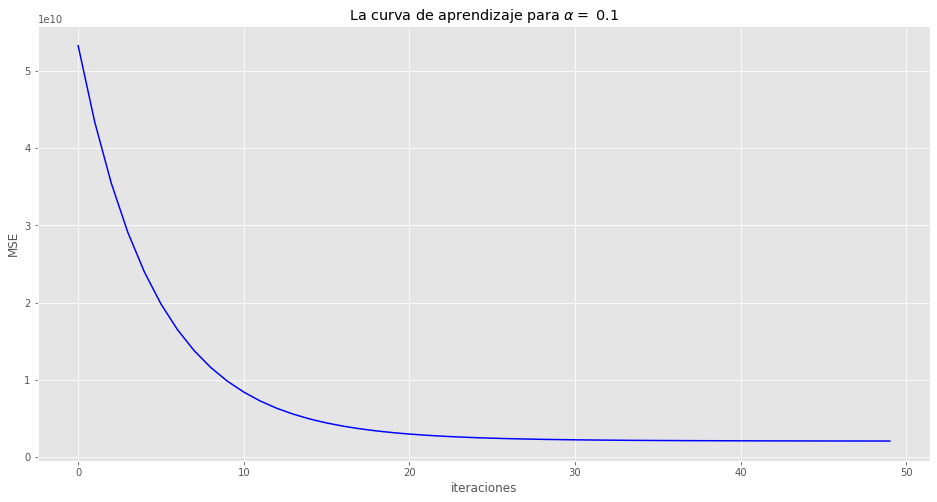

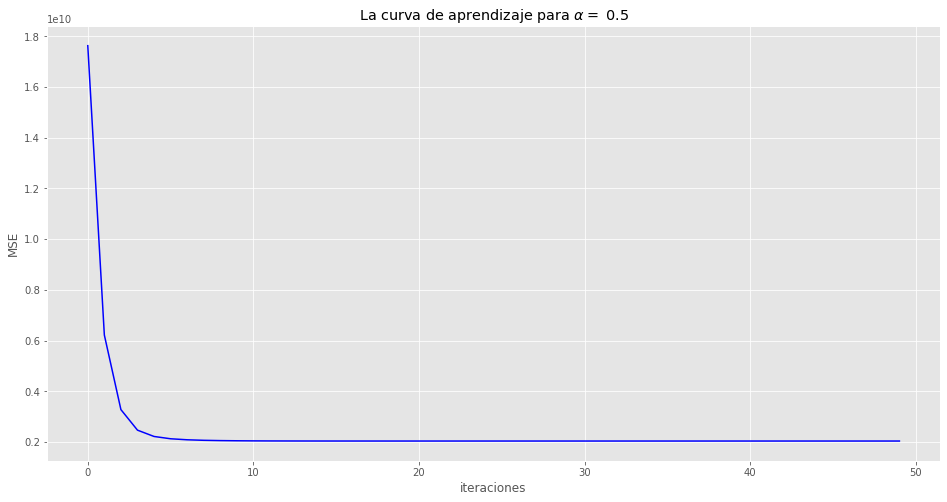

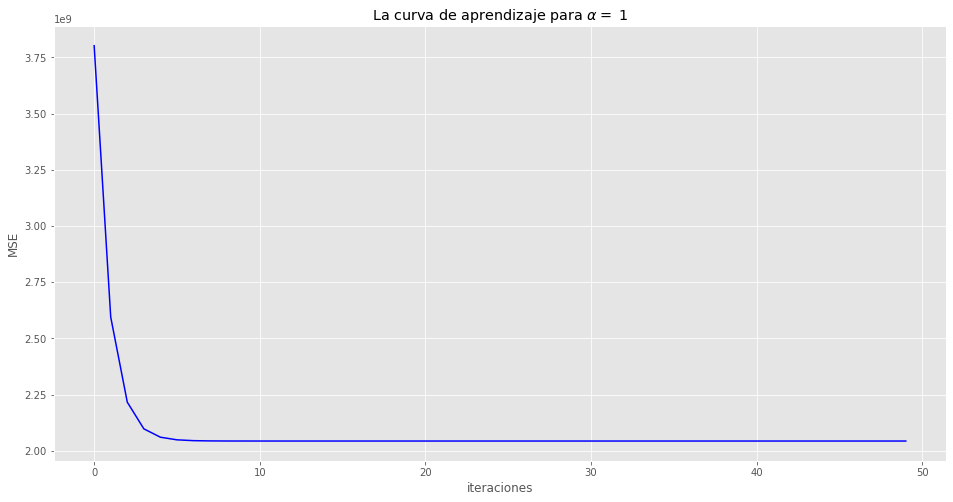

In [170]:
m, n = x.shape
medias, desviaciones = obtiene_medias_desviaciones(x)
x_norm = normaliza(x, medias, desviaciones)

alphas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]

w_list = [0] * len(alphas)
b_list = [0] * len(alphas)
j_list = [0] * len(alphas)
for i in range(len(alphas)):
    w_ini = np.zeros((n,))
    b_ini = 0.0
    num_iters = 50
    alpha = alphas[i]
    w_list[i], b_list[i], mse_hist = descenso_gradiente_lotes(x_norm, y, w_ini, b_ini, alpha, num_iters)
    j_list[i] = mse_hist[-1]
    plt.figure()
    plt.plot(mse_hist, '-b')
    plt.title(r"La curva de aprendizaje para $\alpha =$ " + str(alpha))
    plt.xlabel('iteraciones')
    plt.ylabel('MSE')

Para el anterior ejercicio, seleccionamos el $\alpha=0.5$ por que es el que con menos iteraciones, el error deciende lo suficientemente, not'andose el efecto de codo enla gráfica correspondiente.

**Utilizando las iteraciones necesarias, encuentra el valor de $\omega$ y $b$ utilizando el descenso de gradiente.**

Batch:0 loss:17629115807.239510


Text(0.6, 0.6, 'w =92673.65304713856\n b =329774.7639627659')

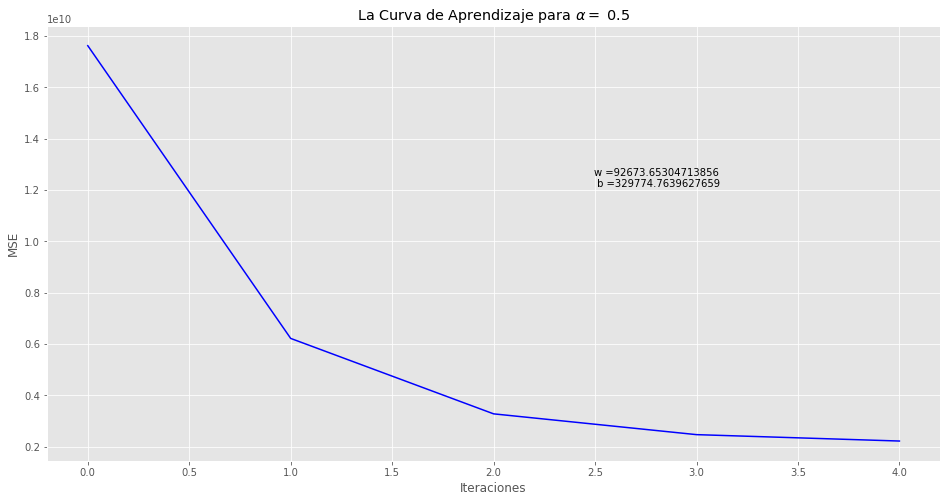

In [172]:
num_iters = 5

alpha = 0.5

w, b, mse_hist = descenso_gradiente_lotes(x_norm, y, w_ini, b_ini, alpha, num_iters)

plt.title(r"La Curva de Aprendizaje para $\alpha =$ " + str(alpha))
plt.plot(mse_hist, '-b')
plt.xlabel('Iteraciones')
plt.ylabel('MSE')
plt.figtext(x = 0.6, y = 0.6, s = "w ={}\n b ={}".format(w[0], b))

**Obten el valor de una casa de 1650 pies cuadrados y 3 recamaras con el modelo obtenido (recuerda que hay que normalizar).**

In [173]:
# Escribe aquí el código
x = np.array([[1650, 3]])
x_norm = normaliza(x, medias, desviaciones)

y_est = x_norm @ w.T +b

print("Precio Estimado: ", y_est)


Precio Estimado:  [286145.04067021]
